## Reinforcement Learning - DQN
### Authors
+ Joao Murackami
+ Samuel Heinrichs

In [1]:
# import libraries

import gym
import numpy as np
import pandas as pd
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
from gym.core import ObservationWrapper
from gym.spaces import Box
from keras.layers import Conv2D, Dense, Flatten
from gym.spaces.box import Box
from gym.core import Wrapper
import random
import tensorflow as tf
import keras
from scipy.misc import imresize
import time

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

%matplotlib inline
np.warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Main variables
GAME_DICT = {'Pong':
             {
                'initial_epsilon': 0.5
                ,'iterations':100000
                ,'exp_size':50000
                ,'eps_decrease':0.995
                ,'batch_size':64
                ,'env_name':'PongDeterministic-v4'
             },
             'Breakout':
             {
                'initial_epsilon': 0.65
                ,'iterations':200000
                ,'exp_size':70000
                ,'eps_decrease':0.995
                ,'batch_size':64
                ,'env_name': 'BreakoutDeterministic-v4'
             }
            }

# What game will be choosen to train?
game = 'Pong'
GAME_DICT = GAME_DICT['Pong']

In [3]:
# Code structure based on yandexdataschool/Practical_RL 

# pre process pixels states
class Preprocess(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self,env)
        #resize img to 84 x 84 x 1
        
        self.img_size = (84, 84, 1)
        self.observation_space = Box(0.0, 1.0, self.img_size
                                     , dtype=np.float32)

    def _observation(self, img):        
        
        # cut image, resize and normalize img
        img = img[35:195, 0:160]
        img = imresize(img, self.img_size)
        img = img.mean(-1, keepdims=True)
        img = img.astype('float32') / 255.
        
        return img

# buffer that stacks 4 frames for each state
class FrameBuffer(Wrapper):
    # stack 4 frames into one state
    def __init__(self, env, n_frames=4):
        super(FrameBuffer, self).__init__(env)
        height, width, n_channels = env.observation_space.shape
        obs_shape = [height, width, n_channels * n_frames]
        self.observation_space = Box(0.0, 1.0, obs_shape, dtype=np.float32)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        offset = self.env.observation_space.shape[-1]
        cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = -1)
        
class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0, gamma = 0.99, lr = 1e-4,  double = False):
            
        self.epsilon = epsilon
        self.gamma = gamma
        self.lr = lr

        # Agent network
        self.network = keras.models.Sequential()
        self.network.add(Conv2D(filters=32, kernel_size=8, strides=4
                                ,activation='relu'
                                ,use_bias=False
                                ,padding='valid'
                                ,kernel_initializer=tf.variance_scaling_initializer(scale=2)
                                ,input_shape=state_shape)) 
        self.network.add(Conv2D(filters=64, kernel_size=4, strides=2
                                ,activation='relu'
                                ,use_bias=False
                                ,padding='valid'
                                ,kernel_initializer=tf.variance_scaling_initializer(scale=2))) 
        self.network.add(Conv2D(filters=64, kernel_size=3, strides=1
                                ,activation='relu'
                                ,use_bias=False
                                ,padding='valid'
                                ,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
        
        self.network.add(Flatten())
        self.network.add(Dense(512
                               ,activation='relu'
                               ,kernel_initializer=tf.variance_scaling_initializer(scale=2))) 
        self.network.add(Dense(n_actions
                               ,activation = 'linear'
                               ,kernel_initializer=tf.variance_scaling_initializer(scale=2))) 
        
        #target network
        self.target_network = keras.models.clone_model(self.network) 

        # placeholders that will be used to do the training
        self.obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
        self.actions_ph = tf.placeholder(tf.int32, shape=[None])
        self.rewards_ph = tf.placeholder(tf.float32, shape=[None])
        self.next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
        self.is_done_ph = tf.placeholder(tf.float32, shape=[None])
        self.is_not_done = 1 - self.is_done_ph

        # q-values based on choosed actions
        self.action_qvalues = tf.reduce_sum(tf.one_hot(self.actions_ph, n_actions) * self.network(self.obs_ph), axis=1)
        if double:
            # Use DDQN here
            self.next_qvalues = self.target_network(self.next_obs_ph)
            self.next_qvalues_agent = self.network(self.next_obs_ph)
            self.next_action = tf.argmax(self.next_qvalues_agent, axis = 1)
            self.next_max_qsa = tf.reduce_sum(self.next_qvalues * tf.one_hot(self.next_action, n_actions), axis = 1)
        else:
            self.next_max_qsa = tf.reduce_max(self.target_network(self.next_obs_ph), axis=1)
            
        # Target q-value
        self.target_values = self.rewards_ph + self.gamma * tf.multiply(self.next_max_qsa, self.is_not_done)
        # Loss func
        self.td_loss = tf.reduce_mean(tf.losses.huber_loss(labels=self.target_values, predictions=self.action_qvalues))
        self.train_step = tf.train.AdamOptimizer(self.lr).minimize(self.td_loss, var_list=self.network.weights)
        sess.run(tf.global_variables_initializer())

    def get_qvalues(self, s):
        
        return self.network.predict(s)
    
    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)
    
    def transfer_weights(self):
        self.target_network.set_weights(self.network.get_weights())

# replay class that stores n size tuple of experiences
class ExpReplay(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size       

    def __len__(self):
        return len(self._storage)

    def add(self, s, a, r, next_s, done):
        data = (s, a, r, next_s, done)
        
        self._storage.append(data)
        storage_size = len(self._storage)
        if (storage_size >= self._maxsize):
            self._storage = self._storage[storage_size-self._maxsize:]
        
    def sample(self, batch_size):
        idx = np.random.randint(0, len(self._storage), size=batch_size)
        batch = np.array(self._storage)[idx]
        states, actions, rewards, next_states, isdone = [], [], [], [], []
        
        for s, a, r, ns, done in batch:
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(ns)
            isdone.append(done)
        
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(isdone)

In [4]:
# Evaluate agent 
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, render = False):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(s[None])
            
            if render:
                plt.figure(figsize=[15, 4])
                clear_output(True)
                plt.subplot(1, 3, 1)
                plt.imshow(env.render('rgb_array'))
                plt.subplot(1, 3, 2)
                plt.imshow(s[:,:,0],interpolation='none',cmap='gray')
                plt.subplot(1, 3, 3)
                barplot = plt.bar(np.arange(env.action_space.n), qvalues[0])
                barplot[np.argmax(qvalues[0])].set_color('r')
                plt.xticks(np.arange(env.action_space.n), env.unwrapped.get_action_meanings(), rotation='vertical')
                
                plt.show()
            
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

# play the game and save S, A, R, S',D in exp_replay
def play(agent, env, exp_replay, n_steps=1000):
    s = env.framebuffer
    last_info = None
    total_reward = 0
    for steps in range(n_steps):
        
        qvalues = agent.get_qvalues(s[None])
        a = agent.sample_actions(qvalues)[0]
              
        next_s, r, done, info = env.step(a)
        r = -10 if (last_info is not None and last_info['ale.lives'] > info['ale.lives']) else r
        exp_replay.add(s, a, r, next_s, done)
        total_reward += r
        
        if done:
            s = env.reset()
            last_info = None
        else:
            s = next_s
            last_info = info
               
    return total_reward

# create env with preprocess and framebuffer
def create_game(game_name):
    env = gym.make(game_name)
    env = Preprocess(env)
    env = FrameBuffer(env, n_frames=4)
    return env

# batch experience from replay
def sample_batch(exp_replay, batch_size, agent):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        agent.obs_ph:obs_batch
        ,agent.actions_ph:act_batch
        ,agent.rewards_ph:reward_batch
        ,agent.next_obs_ph:next_obs_batch
        ,agent.is_done_ph:is_done_batch
    }

# save network weights
def save_Weights(agent, name):
    agent.network.save_weights('model_' + name + '.h5')
    agent.target_network.save_weights('target_' + name + '.h5')
    
# load network weights
def load_weights(agent, model_path, target_path):
    agent.network.load_weights(model_path)
    agent.target_network.load_weights(target_path)

# fill experience replay tuples
def load_exp(agent, env, size):
    
    exp_replay = ExpReplay(size)
    play(agent, env, exp_replay, n_steps=size)
    
    return exp_replay

# train agent
def train(agent, env, exp_replay, game_dict, steps = 25, inc = 0, games_eval = 3, eval_freq = 100):

    agent.epsilon = game_dict['initial_epsilon']
    batch_size = game_dict['batch_size']
    iterations = game_dict['iterations']
    eps_decrease = game_dict['eps_decrease']
    mean_rw = []
    add_step = 0
    
    for i in trange(iterations):

        # play
        play(agent, env, exp_replay, n_steps = int(steps + add_step))
        # train
        sess.run([agent.train_step, agent.td_loss], sample_batch(exp_replay, batch_size, agent))

        # adjust agent parameters
        if i % 500 == 0:
            add_step += inc
            agent.transfer_weights()
            agent.epsilon = max(agent.epsilon * eps_decrease, 0.01) 

        if i % eval_freq == 0:
            mean_rw.append(evaluate(create_game(GAME_DICT['env_name']), agent, games_eval))
            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[24, 4])
            plt.title("Mean Reward")
            plt.plot(mean_rw)
            plt.grid()
            plt.show()

In [ ]:
# env and agent definition
env = create_game(GAME_DICT['env_name'])
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

agent = DQNAgent(state_dim, n_actions, epsilon=0.5, double=False)
expreplay = load_exp(agent, env, GAME_DICT['exp_size'])
sess.run(tf.global_variables_initializer())

buffer size = 50000, epsilon = 0.18348


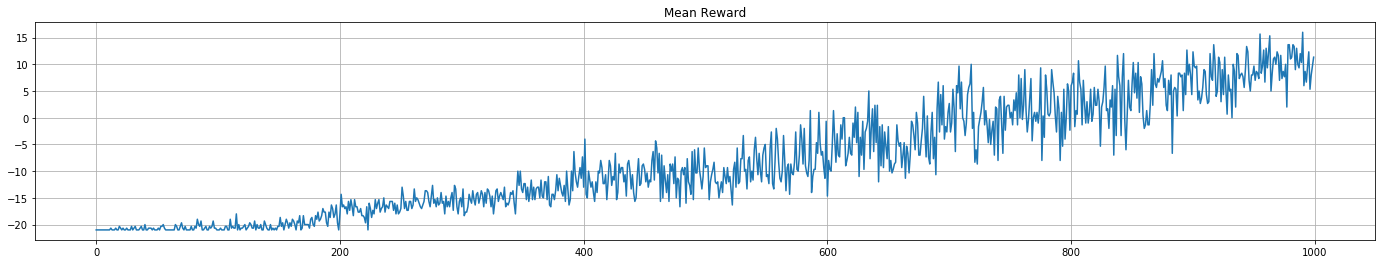

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [10:13:49<00:00,  2.72it/s]


In [6]:
# execute training
train(agent, env, expreplay, GAME_DICT)

In [ ]:
save_Weights(agent, 'pong_agent_best_21_' + str(np.random.choice(10000))